In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import category_encoders as ce
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
# suppress warning messages
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r'/Users/lauverm/Desktop/accepted_2007_to_2018Q4.csv')

In [3]:
#finding the columns with the least null values
a = pd.DataFrame()
a['Percentage of null values']=['10% or less','20% or less','30% or less','40% or less','50% or less','60% or less','70% or less']

ten_percent = len(df.columns[((df.isnull().sum())/len(df)) < 0.1])
twenty_percent = len(df.columns[((df.isnull().sum())/len(df)) < 0.2])
thirty_percent = len(df.columns[((df.isnull().sum())/len(df)) < 0.3])
fourty_percent = len(df.columns[((df.isnull().sum())/len(df)) < 0.4])
fifty_percent = len(df.columns[((df.isnull().sum())/len(df)) < 0.5])
sixty_percent = len(df.columns[((df.isnull().sum())/len(df)) < 0.6])
seventy_percent = len(df.columns[((df.isnull().sum())/len(df)) < 0.7])


a['No.of columns'] = [ten_percent,twenty_percent,thirty_percent,fourty_percent,fifty_percent,sixty_percent,seventy_percent]
a
# choosing to select columns with 20% or less null values - given over 2.2 million rows, the difference is some 44K values

,Percentage of null values,No.of columns
0,10% or less,92
1,20% or less,93
2,30% or less,93
3,40% or less,105
4,50% or less,107
5,60% or less,109
6,70% or less,110


In [4]:
df = df[df.columns[((df.isnull().sum())/len(df)) < 0.2]]
df.shape

(2260701, 93)

In [5]:
#addressing the question about factors influencing on time loan status

In [6]:
loan_status = df['loan_status'].unique().tolist()

In [7]:
df = df[df['loan_status'].isin(loan_status)]

In [8]:
df.dropna(axis = 0, inplace = True)

In [9]:
df['loan_status'].value_counts()

Fully Paid            790625
Current               641230
Charged Off           195388
Late (31-120 days)     15742
In Grace Period         6347
Late (16-30 days)       3092
Default                   28
Name: loan_status, dtype: int64

In [10]:
#Question is "what factors explain late vs on-time payment". This suggests that fully paid are not relevant 
#because at some point in those loans people could have been late, but we would not know now. 2.
#charged-off means there is no expectation of ability to pay - which means they are late but off the books. So 
#I'll remove loans that are both fully paid and charged off.

In [11]:
status_to_remove = ['Fully Paid', 'Charged Off']

In [12]:
df = df[~df['loan_status'].isin(status_to_remove)]

In [13]:
df.shape

(666439, 93)

In [14]:
#convert remaining loan_status to either late or on-time
expression = df['loan_status'].isin(['Late (31-120 days)', 'Late (16-30 days)', 'In Grace Period', 'Default'])

In [15]:
# 0 late and 1 is ontime
df['new_loan_status'] = np.where(expression, 0, 1)

In [16]:
df['emp_length'] = df['emp_length'].str.replace(' years', '')
df['emp_length'] = df['emp_length'].str.replace('+', '')
df['emp_length'] = df['emp_length'].str.replace(' year', '')
df['emp_length'] = df['emp_length'].str.replace('< ', '')

In [17]:
df['term'] = df['term'].str.replace(' months', '')

In [18]:
df['issue_d'] = pd.to_datetime(df['issue_d'])
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'])
df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'])

In [19]:
del df['loan_status']

In [20]:
df.shape

(666439, 93)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 666439 entries, 10 to 2260695
Data columns (total 93 columns):
id                            666439 non-null object
loan_amnt                     666439 non-null float64
funded_amnt                   666439 non-null float64
funded_amnt_inv               666439 non-null float64
term                          666439 non-null object
int_rate                      666439 non-null float64
installment                   666439 non-null float64
grade                         666439 non-null object
sub_grade                     666439 non-null object
emp_title                     666439 non-null object
emp_length                    666439 non-null object
home_ownership                666439 non-null object
annual_inc                    666439 non-null float64
verification_status           666439 non-null object
issue_d                       666439 non-null datetime64[ns]
pymnt_plan                    666439 non-null object
url                      

In [22]:
pd.set_option('max_columns', None)
df.head(n=2)

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,new_loan_status
10,68356421,22400.0,22400.0,22400.0,60,12.88,508.30,C,C2,Executive Director,6,MORTGAGE,95000.0,Not Verified,2015-12-01,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,290xx,SC,22.98,0.0,1995-04-01,710.0,714.0,0.0,16.0,0.0,13028.0,32.7,35.0,w,9912.88,9912.88,19275.33,19275.33,12487.12,6788.21,0.0,0.0,0.0,2019-02-01,508.30,2019-03-01,589.0,585.0,0.0,1.0,Individual,0.0,0.0,376218.0,39800.0,9.0,23514.0,12617.0,39.9,0.0,0.0,150.0,248.0,1.0,1.0,5.0,1.0,14.0,2.0,3.0,8.0,4.0,5.0,15.0,10.0,15.0,8.0,16.0,0.0,0.0,0.0,3.0,97.0,25.0,0.0,0.0,436841.0,184356.0,21000.0,191682.0,N,Cash,N,1
11,68426545,16000.0,16000.0,16000.0,60,12.88,363.07,C,C2,Senior Structural Designer,1,MORTGAGE,70000.0,Not Verified,2015-12-01,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,786xx,TX,26.40,0.0,1988-02-01,720.0,724.0,0.0,13.0,0.0,28705.0,56.3,29.0,w,7080.70,7080.70,13768.04,13768.04,8919.30,4848.74,0.0,0.0,0.0,2019-02-01,363.07,2019-03-01,754.0,750.0,0.0,1.0,Individual,0.0,0.0,265836.0,51000.0,3.0,24167.0,17922.0,61.0,0.0,0.0,147.0,334.0,9.0,9.0,2.0,9.0,11.0,0.0,4.0,6.0,5.0,12.0,6.0,10.0,21.0,6.0,13.0,0.0,0.0,0.0,1.0,100.0,60.0,0.0,0.0,309638.0,62407.0,45900.0,45838.0,N,Cash,N,1


In [23]:
#continue to look for columns to remove from data, there were only two rows where there was a difference between loan amount and funded_amt. 
#Keeping funded_amnt because it is the amount of money an applicant recieved.
df[df['loan_amnt'] != df['funded_amnt']]

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,new_loan_status
684043,80749289,18000.0,10000.0,10000.0,36,12.99,336.90,C,C2,Manager,6,RENT,60000.0,Source Verified,2016-06-01,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,Business,980xx,WA,20.45,0.0,2008-11-01,685.0,689.0,1.0,9.0,0.0,15537.0,43.4,12.0,w,273.39,273.39,11660.48,11660.48,9726.61,1933.87,0.0,0.0,0.0,2019-03-01,336.90,2019-03-01,694.0,690.0,0.0,1.0,Individual,0.0,155.0,28657.0,35800.0,1.0,3184.0,19046.0,39.7,0.0,0.0,74.0,90.0,4.0,4.0,0.0,43.0,4.0,0.0,4.0,5.0,5.0,6.0,2.0,7.0,9.0,5.0,9.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,56761.0,28657.0,31600.0,20045.0,N,Cash,N,1
684121,79101538,20000.0,10000.0,10000.0,36,7.39,310.56,A,A4,manager,10,MORTGAGE,55000.0,Verified,2016-06-01,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,114xx,NY,20.77,0.0,1996-07-01,705.0,709.0,0.0,10.0,0.0,16751.0,61.4,37.0,w,920.52,920.52,10244.37,10244.37,9079.48,1164.89,0.0,0.0,0.0,2019-03-01,310.56,2019-03-01,744.0,740.0,0.0,1.0,Joint App,0.0,0.0,53218.0,27300.0,3.0,6652.0,4263.0,69.5,0.0,0.0,112.0,237.0,10.0,10.0,6.0,10.0,12.0,1.0,2.0,3.0,5.0,18.0,2.0,8.0,28.0,3.0,10.0,0.0,0.0,0.0,2.0,97.3,66.7,0.0,0.0,190551.0,18450.0,14000.0,3251.0,N,Cash,N,1


In [24]:
df.drop(['id', 'loan_amnt','emp_title','pymnt_plan','url','title','zip_code','addr_state', 'initial_list_status'], axis=1, inplace=True)

In [25]:
df.shape

(666439, 84)

In [26]:
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
df.corr().sort_values(by='new_loan_status')

,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,new_loan_status
total_rec_late_fee,0.062951,0.062925,0.065081,0.075042,0.015238,-0.003865,0.036685,-0.035666,-0.035665,0.019630,0.001616,0.010221,0.013470,0.033846,0.012038,0.009558,0.009547,0.119183,0.119177,0.098162,0.127314,1.000000,NaN,NaN,0.041296,-0.113631,-0.105537,0.003993,NaN,0.008430,-0.000293,0.025811,-0.006152,0.011050,0.024588,-0.023640,0.028266,0.003451,0.005739,0.008895,0.002289,0.004942,-0.003021,0.012218,0.004858,-0.019825,0.009022,-0.002175,0.001212,-0.008704,-0.001996,0.019398,-0.008938,-0.004117,0.001514,0.001565,0.004916,0.007731,0.009250,0.009890,-0.028894,0.028408,-0.005390,0.018343,0.021952,0.027680,-0.014690,0.025637,-0.216799
int_rate,0.052831,0.052892,1.000000,0.088824,-0.042962,0.140112,0.075959,-0.432834,-0.432831,0.128022,-0.022039,0.051118,-0.026059,0.297090,-0.052362,0.094380,0.094419,0.130474,0.130504,-0.049050,0.443789,0.065081,NaN,NaN,0.035543,-0.368827,-0.343538,0.023105,NaN,0.011509,0.022836,-0.094136,-0.211810,0.130532,-0.088191,-0.318146,0.307340,0.017617,0.001870,-0.051919,-0.128405,-0.063844,-0.084039,-0.117187,-0.050565,-0.108353,0.068027,0.023632,0.078965,-0.075783,-0.100529,0.020848,-0.031309,-0.071917,0.079224,-0.022342,0.005927,0.009189,0.043120,0.127295,-0.103095,0.296594,0.050610,0.017213,-0.137244,0.014891,-0.254305,0.003938,-0.109539
total_rec_int,0.547810,0.547727,0.443789,0.479577,0.051517,0.069187,0.048537,-0.145954,-0.145952,0.046876,0.091909,0.032872,0.169635,0.251125,0.123210,0.208000,0.207969,0.846205,0.846245,0.664237,1.000000,0.127314,NaN,NaN,0.192548,-0.126228,-0.114555,-0.010037,NaN,0.031654,-0.003437,0.118662,0.065998,0.024248,0.079680,-0.078547,0.230738,0.008265,0.007216,0.086607,0.099330,0.006850,-0.001868,0.125588,0.017836,-0.041962,-0.007318,0.114464,0.135827,0.064590,0.099483,0.058854,0.076773,0.098164,0.137086,0.091602,0.009350,0.028775,0.010640,0.008328,0.002176,0.212315,-0.024595,0.055405,0.109475,0.145058,0.046144,0.103461,-0.072688
acc_open_past_24mths,-0.007837,-0.007866,0.130532,0.010259,0.028996,0.066192,-0.062840,-0.084249,-0.084251,0.257336,0.485343,0.076972,0.000644,-0.226837,0.411527,0.018320,0.018294,-0.020823,-0.020850,-0.041914,0.024248,0.011050,NaN,NaN,0.010462,-0.130684,-0.121991,0.007909,NaN,-0.008156,0.024220,0.107820,0.150853,1.000000,-0.075021,0.168561,-0.192085,0.001143,-0.005746,0.003838,-0.055249,-0.394606,-0.448814,0.058159,-0.331934,-0.226344,0.073113,0.259956,0.347973,0.355984,0.326499,0.210740,0.481254,0.406087,0.348121,0.484772,-0.003115,-0.008840,-0.034364,0.755370,0.066904,-0.174467,0.095820,0.011580,0.119914,0.146432,0.106090,0.161164,-0.041759
total_pymnt,0.580256,0.580069,0.130474,0.565642,0.083297,0.020242,0.044798,-0.049682,-0.049681,0.015835,0.107540,0.024756,0.214787,0.202175,0.147529,0.051571,0.051512,1.000000,0.999996,0.960401,0.846205,0.119183,NaN,NaN,0.307687,-0.033771,-0.028688,-0.014730,NaN,0.034641,-0.006920,0.167918,0.154061,-0.020823,0.120125,0.020169,0.177019,0.005874,0.010542,0.104821,0.158431,0.025507

In [27]:
#based on df.corr, I'm deleting policy_code, collection_recovery_fee, and recoveries because there is no correlation
#between these values and the target value.

df.drop(['policy_code','collection_recovery_fee','recoveries'], axis = 1, inplace = True)

In [28]:
#reducing size of data types (and ultimately df) to help improve model runtime.
df[df.select_dtypes(np.float64).columns] = df.select_dtypes(np.float64).astype(np.float32)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 666439 entries, 10 to 2260695
Data columns (total 81 columns):
funded_amnt                   666439 non-null float32
funded_amnt_inv               666439 non-null float32
term                          666439 non-null object
int_rate                      666439 non-null float32
installment                   666439 non-null float32
grade                         666439 non-null object
sub_grade                     666439 non-null object
emp_length                    666439 non-null object
home_ownership                666439 non-null object
annual_inc                    666439 non-null float32
verification_status           666439 non-null object
issue_d                       666439 non-null datetime64[ns]
purpose                       666439 non-null object
dti                           666439 non-null float32
delinq_2yrs                   666439 non-null float32
earliest_cr_line              666439 non-null datetime64[ns]
fico_range_low  

In [30]:
df.corr(method='spearman')[['new_loan_status']].sort_values(by = 'new_loan_status', ascending=False)

,new_loan_status
new_loan_status,1.000000
last_fico_range_low,0.227031
last_fico_range_high,0.227031
fico_range_low,0.059416
fico_range_high,0.059416
total_bc_limit,0.045473
bc_open_to_buy,0.043529
total_rev_hi_lim,0.041865
mths_since_recent_inq,0.036091
mo_sin_old_rev_tl_op,0.025795


In [31]:
#dropping columns that have negative correlation or no correlation with the target column new_loan_status
df.drop(['num_actv_bc_tl','total_il_high_credit_limit','delinq_amnt','num_il_tl','acc_now_delinq','collections_12_mths_ex_med',
        'num_tl_30dpd','chargeoff_within_12_mths','num_actv_rev_tl','num_rev_tl_bal_gt_0','dti','tot_coll_amt',
        'pub_rec_bankruptcies','num_tl_90g_dpd_24m','tax_liens','pub_rec','revol_util','num_accts_ever_120_pd',
        'delinq_2yrs','bc_util','out_prncp','out_prncp_inv','percent_bc_gt_75','total_rec_prncp','funded_amnt_inv',
        'funded_amnt','inq_last_6mths','last_pymnt_amnt','num_tl_op_past_12m','num_tl_op_past_12m', 'installment',
        'acc_open_past_24mths','total_pymnt_inv','total_rec_int','int_rate','total_rec_late_fee'], axis = 1, inplace = True)

In [32]:
df.shape

(666439, 46)

In [33]:
df.to_csv('cleaned_data_set.csv', index=False)

In [34]:
df = pd.read_csv('cleaned_data_set.csv')

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666439 entries, 0 to 666438
Data columns (total 46 columns):
term                     666439 non-null int64
grade                    666439 non-null object
sub_grade                666439 non-null object
emp_length               666439 non-null int64
home_ownership           666439 non-null object
annual_inc               666439 non-null float64
verification_status      666439 non-null object
issue_d                  666439 non-null object
purpose                  666439 non-null object
earliest_cr_line         666439 non-null object
fico_range_low           666439 non-null float64
fico_range_high          666439 non-null float64
open_acc                 666439 non-null float64
revol_bal                666439 non-null float64
total_acc                666439 non-null float64
total_pymnt              666439 non-null float64
last_pymnt_d             666439 non-null object
last_credit_pull_d       666439 non-null object
last_fico_range_high

In [36]:
df[df.select_dtypes(np.float64).columns] = df.select_dtypes(np.float64).astype(np.float32)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666439 entries, 0 to 666438
Data columns (total 46 columns):
term                     666439 non-null int64
grade                    666439 non-null object
sub_grade                666439 non-null object
emp_length               666439 non-null int64
home_ownership           666439 non-null object
annual_inc               666439 non-null float32
verification_status      666439 non-null object
issue_d                  666439 non-null object
purpose                  666439 non-null object
earliest_cr_line         666439 non-null object
fico_range_low           666439 non-null float32
fico_range_high          666439 non-null float32
open_acc                 666439 non-null float32
revol_bal                666439 non-null float32
total_acc                666439 non-null float32
total_pymnt              666439 non-null float32
last_pymnt_d             666439 non-null object
last_credit_pull_d       666439 non-null object
last_fico_range_high

In [38]:
df.head()

,term,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,earliest_cr_line,fico_range_low,fico_range_high,open_acc,revol_bal,total_acc,total_pymnt,last_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,application_type,tot_cur_bal,total_rev_hi_lim,avg_cur_bal,bc_open_to_buy,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_bc_sats,num_bc_tl,num_op_rev_tl,num_rev_accts,num_sats,num_tl_120dpd_2m,pct_tl_nvr_dlq,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,hardship_flag,disbursement_method,debt_settlement_flag,new_loan_status
0,60,C,C2,6,MORTGAGE,95000.0,Not Verified,2015-12-01,debt_consolidation,1995-04-01,710.0,714.0,16.0,13028.0,35.0,19275.330078,2019-02-01,2019-03-01,589.0,585.0,Individual,376218.0,39800.0,23514.0,12617.0,150.0,248.0,1.0,1.0,5.0,1.0,14.0,4.0,5.0,10.0,15.0,16.0,0.0,97.000000,436841.0,184356.0,21000.0,N,Cash,N,1
1,60,C,C2,1,MORTGAGE,70000.0,Not Verified,2015-12-01,debt_consolidation,1988-02-01,720.0,724.0,13.0,28705.0,29.0,13768.040039,2019-02-01,2019-03-01,754.0,750.0,Individual,265836.0,51000.0,24167.0,17922.0,147.0,334.0,9.0,9.0,2.0,9.0,11.0,5.0,12.0,10.0,21.0,13.0,0.0,100.000000,309638.0,62407.0,45900.0,N,Cash,N,1
2,60,B,B1,5,RENT,64000.0,Not Verified,2015-12-01,credit_card,2001-09-01,700.0,704.0,21.0,24940.0,33.0,17900.140625,2019-02-01,2019-03-01,744.0,740.0,Individual,63886.0,47300.0,3549.0,15603.0,163.0,171.0,8.0,8.0,0.0,12.0,8.0,7.0,8.0,14.0,19.0,21.0,0.0,87.900002,93962.0,63886.0,39500.0,N,Cash,N,1
3,60,C,C2,10,MORTGAGE,118000.0,Not Verified,2015-12-01,debt_consolidation,1997-06-01,680.0,684.0,11.0,7849.0,46.0,14456.690430,2019-02-01,2017-11-01,759.0,755.0,Individual,314793.0,32600.0,28618.0,4751.0,126.0,222.0,11.0,11.0,4.0,11.0,11.0,4.0,22.0,5.0,28.0,11.0,0.0,64.400002,412771.0,75808.0,12600.0,N,Cash,N,1
4,60,C,C4,9,MORTGAGE,142000.0,Verified,2015-12-01,debt_consolidation,2004-10-01,680.0,684.0,15.0,2273.0,19.0,14112.889648,2019-02-01,2019-03-01,689.0,685.0,Individual,667373.0,5700.0,47670.0,2827.0,134.0,98.0,23.0,17.0,1.0,23.0,4.0,4.0,5.0,7.0,8.0,15.0,0.0,73.699997,704224.0,112166.0,5100.0,N,Cash,N,1


In [39]:
df['new_loan_status'].mean()

0.962173582278348

In [40]:
#converting date columns to date time formats and creating two different features measuring the mean of both last pulled and first pulled fico scores

In [41]:
df['last_mean_fico'] = (df['last_fico_range_high'] + df['last_fico_range_low'])/2
df['last_mean_fico'] = df['last_mean_fico'].astype(np.int16)
df['mean_fico']      = (df['fico_range_high'] + df['fico_range_low'])/2
df['mean_fico'] = df['mean_fico'].astype(np.int16)
df['issue_d'] = pd.to_datetime(df['issue_d'])
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'])
df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'])

In [42]:
def split_data(df, split_frac=0.2, random_state = 42):
    df = df.drop(['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d'], axis=1)
    X = df.drop('new_loan_status', axis = 1)
    y = df['new_loan_status']
    #stratify to make sure equal distribution of y thoughout the train
    return train_test_split(X, y, test_size = split_frac, stratify = y, random_state = random_state)

def get_feature_importances(pipe, X_train, onehot=False):
    if onehot:
        X_train = pipe[0].transform(X_train)
        X_train = pipe[1].transform(X_train)
    return pd.DataFrame({
        'Col': X_train.columns,
        'Importance': pipe[-1].feature_importances_
    }).sort_values(by='Importance', ascending = False)

In [43]:
def get_model_scores(mod, X_train, y_train, X_test, y_test, val_score = True, test_score=False):
    if val_score:
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                          test_size = 0.2, 
                                                          stratify = y_train, 
                                                          random_state= 42)
 
    mod.fit(X_train, y_train)
    
    results = {}
    
    results['train_score'] = mod.score(X_train, y_train)
    if val_score:
        results['val_score'] = mod.score(X_val, y_val)
        
    if test_score:
        results['test_score'] = mod.score(X_test, y_test)
        
    return results

In [44]:
X_train, X_test, y_train, y_test = split_data(df)

te   = ce.TargetEncoder(min_samples_leaf = 30)

mod  = XGBClassifier(eval_metric = 'logloss')

pipe = make_pipeline(te, mod)

scores = get_model_scores(pipe, X_train, y_train, X_test, y_test, test_score = True)

scores

{'train_score': 0.9647027103066679,
 'val_score': 0.9645787810299069,
 'test_score': 0.9645804573555009}

In [45]:
#all scores are very close in the high 90s

In [46]:
feats = get_feature_importances(pipe, X_train)
feats

,Col,Importance
14,last_fico_range_high,0.298817
2,sub_grade,0.105030
38,hardship_flag,0.097633
8,fico_range_low,0.071006
13,total_pymnt,0.063609
40,debt_settlement_flag,0.051775
16,application_type,0.039941
11,revol_bal,0.028107
5,annual_inc,0.025148
20,bc_open_to_buy,0.023669


In [47]:
#note the new features I made with average fico scores had zero impact on model.

In [48]:
#deleting following rows because feature importance is 0
df.drop(['mean_fico','last_fico_range_low','fico_range_high','mort_acc','avg_cur_bal','num_tl_120dpd_2m',
        'num_op_rev_tl','last_mean_fico','disbursement_method'], axis = 1, inplace = True)

In [49]:
#re-running model after deleting columns with 0 importance on model

In [50]:
X_train, X_test, y_train, y_test = split_data(df)

te   = ce.TargetEncoder(min_samples_leaf = 30)

mod  = XGBClassifier(eval_metric = 'logloss')

pipe = make_pipeline(te, mod)

scores = get_model_scores(pipe, X_train, y_train, X_test, y_test, test_score = True)

# scores didn't budge from last model.
scores

{'train_score': 0.9646769201913158,
 'val_score': 0.9646725623880485,
 'test_score': 0.9647004981693776}

In [51]:
#no change here either.
feats = get_feature_importances(pipe, X_train)
feats

,Col,Importance
13,last_fico_range_high,0.298220
2,sub_grade,0.105341
32,hardship_flag,0.097923
8,fico_range_low,0.077151
12,total_pymnt,0.066766
33,debt_settlement_flag,0.051929
14,application_type,0.040059
17,bc_open_to_buy,0.029674
10,revol_bal,0.028190
5,annual_inc,0.025223


In [52]:
#switching to ordinal encoding
ore   = ce.OrdinalEncoder()

pipe = make_pipeline(ore, mod)

scores = get_model_scores(pipe, X_train, y_train, X_test, y_test)

scores

{'train_score': 0.9646980211947858, 'val_score': 0.9645506466224644}

In [53]:
#training and val_score remain very similar; although when looking at feature importance, last_fico_range jumped up 4pts.

In [54]:
feats = get_feature_importances(pipe, X_train)
feats

,Col,Importance
13,last_fico_range_high,0.327327
32,hardship_flag,0.093093
12,total_pymnt,0.081081
8,fico_range_low,0.063063
1,grade,0.058559
33,debt_settlement_flag,0.054054
14,application_type,0.039039
10,revol_bal,0.025526
5,annual_inc,0.022523
28,pct_tl_nvr_dlq,0.021021


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666439 entries, 0 to 666438
Data columns (total 39 columns):
term                     666439 non-null int64
grade                    666439 non-null object
sub_grade                666439 non-null object
emp_length               666439 non-null int64
home_ownership           666439 non-null object
annual_inc               666439 non-null float32
verification_status      666439 non-null object
issue_d                  666439 non-null datetime64[ns]
purpose                  666439 non-null object
earliest_cr_line         666439 non-null datetime64[ns]
fico_range_low           666439 non-null float32
open_acc                 666439 non-null float32
revol_bal                666439 non-null float32
total_acc                666439 non-null float32
total_pymnt              666439 non-null float32
last_pymnt_d             666439 non-null datetime64[ns]
last_credit_pull_d       666439 non-null datetime64[ns]
last_fico_range_high     666439 non-n

In [56]:
df['debt_settlement_flag'].value_counts()

N    665768
Y       671
Name: debt_settlement_flag, dtype: int64

In [57]:
# onehot encoder + target encoder
ohe = ce.OneHotEncoder(cols = ['grade', 'sub_grade', 'emp_length', 'home_ownership','verification_status','purpose','application_type','hardship_flag','debt_settlement_flag'], use_cat_names = True)
te  = ce.TargetEncoder()

pipe = make_pipeline(ohe, te, mod)

scores = get_model_scores(pipe, X_train, y_train, X_test, y_test)

# scores align very closely to original model
scores

{'train_score': 0.9646698865234925, 'val_score': 0.9645600247582785}

In [58]:
feats = get_feature_importances(pipe, X_train, onehot=True)
feats

,Col,Importance
79,last_fico_range_high,0.308715
99,hardship_flag_N,0.097489
78,total_pymnt,0.076809
74,fico_range_low,0.066470
101,debt_settlement_flag_N,0.050222
80,application_type_Joint App,0.042836
3,grade_A,0.036928
57,annual_inc,0.025111
1,grade_B,0.022157
84,bc_open_to_buy,0.022157


In [ ]:
#Feature scores here make sense - for example high fico range suggests more credity worthiness, 
#no indication of financial hardship suggests ability to repay. Looking at feature importances with 0 such as
#hardship_flag_y and debt_settlement_flag_Y, would have the opposite affect and suggest an inability to repay

In [59]:
# parameter search
estimators = [100, 200, 300, 400]
max_depth  = [3, 4]
sub_sample = [0.8, 0.6] # this is the amount of samples to randomly sample in each round
cv_scores  = []

# do a training loop
for estimator in estimators:
    for depth in max_depth:
        for sample in sub_sample:
            print(f"Fitting new training loop for rounds: {estimator}, depth: {depth}, sampling rate: {sample}")
            pipe[-1].set_params(n_estimators = estimator, max_depth = depth, subsample = sample)
            scores = get_model_scores(pipe, X_train, y_train, X_test, y_test)
            cv_scores.append((scores['train_score'], scores['val_score'], estimator, depth, sample))

Fitting new training loop for rounds: 100, depth: 3, sampling rate: 0.8
Fitting new training loop for rounds: 100, depth: 3, sampling rate: 0.6
Fitting new training loop for rounds: 100, depth: 4, sampling rate: 0.8
Fitting new training loop for rounds: 100, depth: 4, sampling rate: 0.6
Fitting new training loop for rounds: 200, depth: 3, sampling rate: 0.8
Fitting new training loop for rounds: 200, depth: 3, sampling rate: 0.6
Fitting new training loop for rounds: 200, depth: 4, sampling rate: 0.8
Fitting new training loop for rounds: 200, depth: 4, sampling rate: 0.6
Fitting new training loop for rounds: 300, depth: 3, sampling rate: 0.8
Fitting new training loop for rounds: 300, depth: 3, sampling rate: 0.6
Fitting new training loop for rounds: 300, depth: 4, sampling rate: 0.8
Fitting new training loop for rounds: 300, depth: 4, sampling rate: 0.6
Fitting new training loop for rounds: 400, depth: 3, sampling rate: 0.8
Fitting new training loop for rounds: 400, depth: 3, sampling ra

In [60]:
max(cv_scores, 
    key = lambda x: x[1])

(0.9655842633405233, 0.964869503240146, 200, 4, 0.8)

In [61]:
pipe[-1].set_params(n_estimators = 200, max_depth = 4, subsample = 0.8)

scores = get_model_scores(pipe, X_train, y_train, X_test, y_test, val_score = False, test_score = True)

scores

{'train_score': 0.9655050820499258, 'test_score': 0.9649780925514675}

In [62]:
from pdpbox import pdp, info_plots

In [63]:
X_train = pipe[0].transform(X_train)
X_train = pipe[1].transform(X_train)

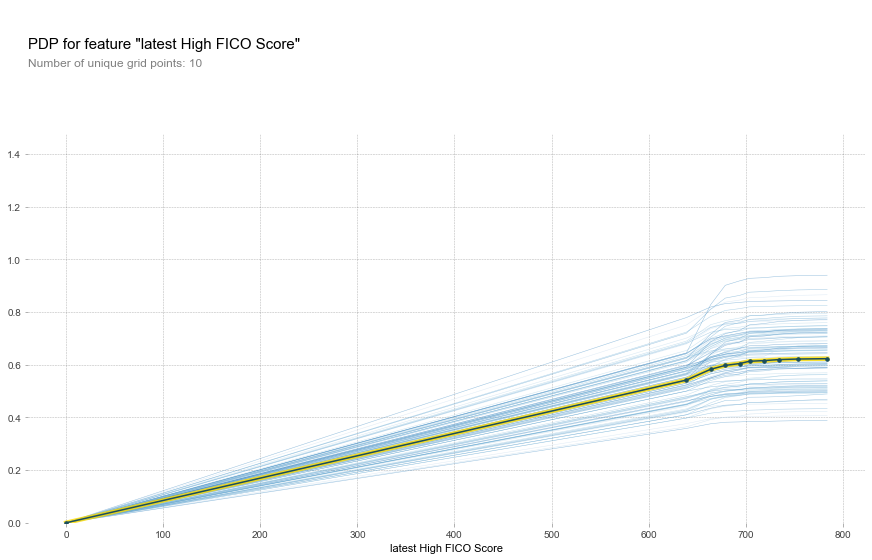

In [68]:
pdp_last_fico = pdp.pdp_isolate(
    model = pipe[-1],
    dataset = X_train[X_train['last_fico_range_high'] < X_train['last_fico_range_high'].quantile(.95)],
    model_features = X_train.columns.to_list(),
    feature='last_fico_range_high'
)

fig, axes = pdp.pdp_plot(pdp_last_fico, 'latest High FICO Score', plot_lines = True, frac_to_plot = 100)

In [71]:
df['last_fico_range_high'].describe()

count    666439.000000
mean        701.888123
std          54.425663
min           0.000000
25%         674.000000
50%         704.000000
75%         734.000000
max         850.000000
Name: last_fico_range_high, dtype: float64

In [ ]:
#PDP plot shows that fico scores between ~620 and 650 show a significant improvement in the ability to repay 
#Furthermore, the differences between an applicant with a score of ~670 and 850 and their ability to repay are marginal

In [76]:
pdp_cat = pdp.pdp_isolate(
    model = pipe[-1], dataset = X_train, model_features = X_train.columns.tolist(),
    feature = 'fico_range_low'
)

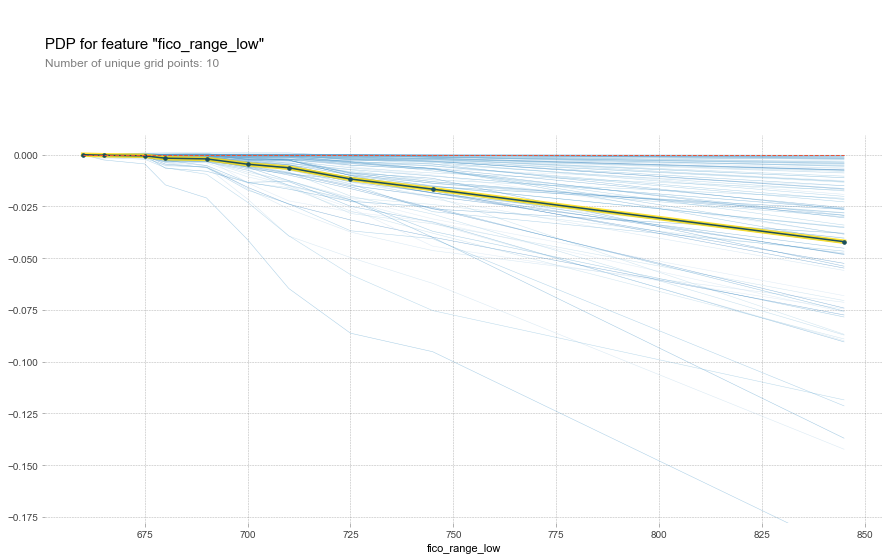

In [77]:
fig, axes = pdp.pdp_plot(pdp_cat,'fico_range_low', plot_lines=True, frac_to_plot = 100)